# Using State Diagrams to construct TTNOs

In [1]:
# Import PyTreeNet from local folders
import sys
sys.path.append('..')
import pytreenet as ptn

import numpy as np
import matplotlib.pyplot as plt

## Toy Example
We consider the rather arbitrary operator
$$
H = Y_2X_3X_4 + X_1Y_2Y_6 + X_1Y_2Z_5 + Z_5X_7X_8,
$$

where $X$, $Y$ and $Z$ are the usual Pauli gates. We want to represent this operator as a TTNO.

As a first step we have to define a TTN which serves as a reference for the tree structure. We will use a product TTNS.

In [2]:
ttns = ptn.TreeTensorNetwork()

# Physical legs come last
node1 = ptn.TensorNode(ptn.crandn((1,1,2)), identifier="site1")
node2 = ptn.TensorNode(ptn.crandn((1,1,1,2)), identifier="site2")
node3 = ptn.TensorNode(ptn.crandn((1,2)), identifier="site3")
node4 = ptn.TensorNode(ptn.crandn((1,2)), identifier="site4")
node5 = ptn.TensorNode(ptn.crandn((1,1,1,2)), identifier="site5")
node6 = ptn.TensorNode(ptn.crandn((1,2)), identifier="site6")
node7 = ptn.TensorNode(ptn.crandn((1,1,2)), identifier="site7")
node8 = ptn.TensorNode(ptn.crandn((1,2)), identifier="site8")

ttns.add_root(node1)
ttns.add_child_to_parent(node2, 0, "site1", 0)
ttns.add_child_to_parent(node3, 0, "site2", 1)
ttns.add_child_to_parent(node4, 0, "site2", 2)
ttns.add_child_to_parent(node5, 0, "site1", 1)
ttns.add_child_to_parent(node6, 0, "site5", 1)
ttns.add_child_to_parent(node7, 0, "site5", 2)
ttns.add_child_to_parent(node8, 0, "site7", 1)

Next we have to initialise the operator in the form of a Hamiltonian.

In [3]:
# To allow better performance symbolic values are used for the local operators
X, Y, Z = ptn.pauli_matrices()
conversion_dict = {"X": X, "Y": Y, "Z": Z, "I": np.eye(2)}

term1 = {"site2": "Y", "site3": "X", "site4": "X"}
term2 = {"site1": "X", "site2": "Y", "site6": "Y"}
term3 = {"site1": "X", "site2": "Y", "site5": "Z"}
term4 = {"site5": "Z", "site7": "X", "site8": "X"}

operator = ptn.Hamiltonian(terms=[term1, term2, term3, term4], conversion_dictionary=conversion_dict)
print(operator)
print("------------------------------------------------------")

# To continue, we have to pad with identities
operator.pad_with_identity(ttns, identity="I")
print(operator)

[{'site2': 'Y', 'site3': 'X', 'site4': 'X'}, {'site1': 'X', 'site2': 'Y', 'site6': 'Y'}, {'site1': 'X', 'site2': 'Y', 'site5': 'Z'}, {'site5': 'Z', 'site7': 'X', 'site8': 'X'}]
------------------------------------------------------
[{'site2': 'Y', 'site3': 'X', 'site4': 'X', 'site1': 'I', 'site5': 'I', 'site6': 'I', 'site7': 'I', 'site8': 'I'}, {'site1': 'X', 'site2': 'Y', 'site6': 'Y', 'site3': 'I', 'site4': 'I', 'site5': 'I', 'site7': 'I', 'site8': 'I'}, {'site1': 'X', 'site2': 'Y', 'site5': 'Z', 'site3': 'I', 'site4': 'I', 'site6': 'I', 'site7': 'I', 'site8': 'I'}, {'site5': 'Z', 'site7': 'X', 'site8': 'X', 'site1': 'I', 'site2': 'I', 'site3': 'I', 'site4': 'I', 'site6': 'I'}]


### Via State Diagram
This is all we need to create the TTNO right away:

In [4]:
ttno = ptn.TTNO.from_hamiltonian(operator, ttns)

Inside `TTNO.from_hamiltonian` a state diagram was constructed via

In [5]:
sd = ptn.StateDiagram.from_hamiltonian(operator, ttns)
sd

hyperedges:
label = I; corr_site = site1; connected to ('site1', 'site2'), ('site1', 'site5'), 
label = X; corr_site = site1; connected to ('site1', 'site2'), ('site1', 'site5'), 
label = I; corr_site = site1; connected to ('site1', 'site2'), ('site1', 'site5'), 
label = Y; corr_site = site2; connected to ('site1', 'site2'), ('site2', 'site3'), ('site2', 'site4'), 
label = Y; corr_site = site2; connected to ('site2', 'site3'), ('site2', 'site4'), ('site1', 'site2'), 
label = I; corr_site = site2; connected to ('site2', 'site3'), ('site2', 'site4'), ('site1', 'site2'), 
label = X; corr_site = site3; connected to ('site2', 'site3'), 
label = I; corr_site = site3; connected to ('site2', 'site3'), 
label = X; corr_site = site4; connected to ('site2', 'site4'), 
label = I; corr_site = site4; connected to ('site2', 'site4'), 
label = I; corr_site = site5; connected to ('site1', 'site5'), ('site5', 'site6'), ('site5', 'site7'), 
label = I; corr_site = site5; connected to ('site5', 'site6'), (

### Using one big Tensor
Instead of using the state diagram, we could also have created the full tensor/matrix representing the operator. Note, this works only due to the relatively limited size of this example ($2^{16}$ tensor elements).

In [6]:
full_tensor = operator.to_tensor(ttns)
print(f"tensor shape: {full_tensor.shape}, number of dimensions: {len(full_tensor.shape)}")

tensor shape: (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2), number of dimensions: 16


In this case we have to provide information about, which leg belongs to which site:

In [7]:
leg_dict = {"site1": 0, "site2": 1, "site3": 2, "site4": 3, "site5": 4, "site6": 5, "site7": 6, "site8": 7}

ttno2 = ptn.TTNO.from_tensor(ttns, full_tensor, leg_dict)

### Comparison
Now we want to compare the dimension of both.

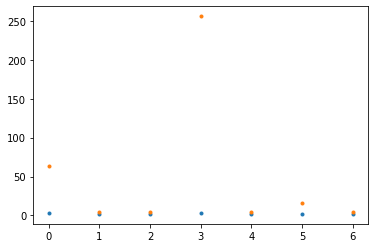

In [11]:
leg_name_list = []
dimensions1 = []
dimensions2 = []

for node_id in ttno.nodes:
    node1 = ttno.nodes[node_id]
    node2 = ttno2.nodes[node_id]
    
    if not node1.is_root():
        leg_name_list.append((node_id, node1.get_parent_id()))
        dimensions1.append(node1.get_parent_leg_dim())
        dimensions2.append(node2.get_parent_leg_dim())

fig = plt.figure()
plt.plot(dimensions1, ".")
plt.plot(dimensions2, ".")
plt.show()